**Zillow Prize:**

https://www.kaggle.com/c/zillow-prize-1/overview

logerror=log(Zestimate)−log(SalePrice)

Goal: Minimize logerror between Zestimate and actual SalePrice

Q: Error 크기 측정시 log를 쓰는 기준이 있는가? 원 데이터가 비선형이고 log를 취했을때 선형으로 바뀔 때 쓰는 것인가?

In [ ]:
**
1. Target distribution
    - Logerror Distribution by index
    - Logerror Histogram
2. Overall data distribution
    - Occurence Histogram by month
3. Missing value
    - Merge with property data
4. Geographic distribution
5. Data type by columns
6. Correlation coefficient with Target
7. Correlation among result 6
8. Distribution of each result 7
9. PCA
    - ExtraTreeRegressor, XGBoost
**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

# description for options
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
# bash command to list the files in the input folder.
from subprocess import check_output
print(check_output(["ls", "./"]).decode("utf8"))

JunPark-zillow-prize.ipynb
properties_2016.csv
properties_2017.csv
sample_submission.csv
train_2016_v2.csv
train_2017.csv
zillow_data_dictionary.xlsx



In [3]:
train_df = pd.read_csv("./train_2016_v2.csv")
# train_df = pd.read_csv("../input/train_2016.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In [4]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [5]:
train_df.dtypes

parcelid             int64
logerror           float64
transactiondate     object
dtype: object

In [6]:
# parse_dates converts column type into datetime64
train_df = pd.read_csv("./train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.dtypes

parcelid                    int64
logerror                  float64
transactiondate    datetime64[ns]
dtype: object

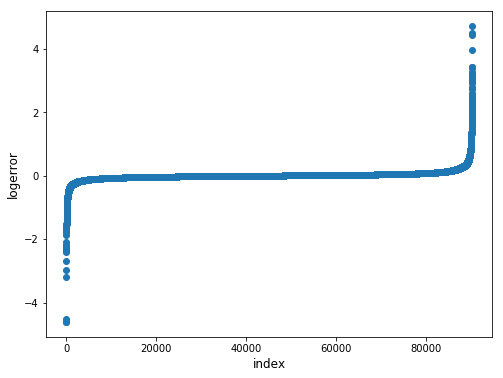

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

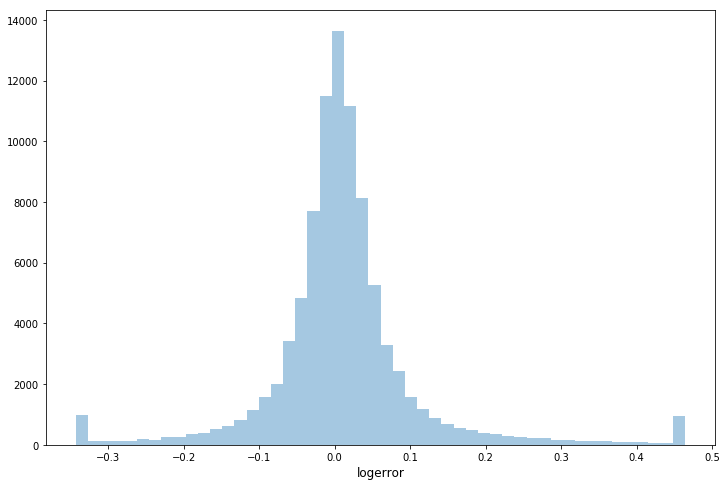

In [8]:
# replace outliers with top 99% and lowest 1%
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'].loc[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].loc[train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

In [46]:
train_df.describe()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.000000,90275.0,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.0,90275.000000,90275.0,90275.0,90275.0,90275.000000,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,90275.0,9.027500e+04,90275.000000,90275.000000,9.027500e+04
mean,1.816372,7.229885,713.581395,2.279474,3.023118,4.0,5.565407,2.309216,66.0,1347.974037,1765.719640,1737.920083,1404.545455,2380.090067,1355.546674,2302.546318,6048.870551,1.187884,2.241231,1.812005,345.521228,3.926979,3.400541e+07,-1.181989e+08,2.911016e+04,1.0,519.827657,1.0,1.0,1.0,261.832179,6.049179e+07,33761.332851,2525.420770,190646.540237,96586.131184,1.478516,7.0,1.008743,6.010033,1.110414,310.142101,311.694737,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5861.901317,13.402692,6.049151e+13
std,1.679305,0.145769,9.435307,1.004271,1.114771,0.0,1.515046,0.969761,0.0,179.777646,869.819224,830.139573,2.073067,212.217924,185.648388,91.827066,20.663461,0.157939,0.956815,0.350560,153.763301,2.903912,2.649654e+05,3.606032e+05,1.146744e+05,0.0,16.056094,0.0,0.0,0.0,5.182901,2.050549e+05,46203.960267,805.694842,104988.759971,3660.629259,2.819627,0.0,0.036774,0.025121,0.640963,37.096611,11.176449,23.663762,0.259909,2.086893e+05,5.548813e+05,0.0,4.004932e+05,5361.598711,0.381590,2.039736e+11
min,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,66.0,44.000000,560.000000,560.000000,1056.000000,560.000000,44.000000,257.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,1.0,28.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,25.000000,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,594.928500,6.000000,6.037101e+13
25%,1.000000,7.229885,713.581395,2.000000,2.000000,4.0,4.000000,2.000000,66.0,1347.974037,1187.000000,1190.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.000000,1.187884,2.000000,1.812005,345.521228,2.000000,3.381154e+07,-1.184117e+08,5.962000e+03,1.0,519.827657,1.0,1.0,1.0,261.000000,6.037320e+07,12447.000000,1286.000000,190646.540237,96193.000000,0.000000,7.0,1.008743,6.010033,1.000000,310.142101,311.694737,1953.000000,1.440739,8.149000e+04,1.990235e+05,2015.0,8.222800e+04,2872.885000,13.402692,6.037400e+13
50%,1.816372,7.229885,713.581395,2.000000,3.000000,4.0,5.565407,2.000000,66.0,1347.974037,1547.000000,1561.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.000000,1.187884,2.000000,1.812005,345.521228,3.926979,3.402150e+07,-1.181734e+08,7.570000e+03,1.0,519.827657,1.0,1.0,1.0,261.000000,6.037620e+07,25458.000000,3101.000000,190646.540237,96393.000000,0.000000,7.0,1.008743,6.010033,1.000000,310.142101,311.694737,1969.00

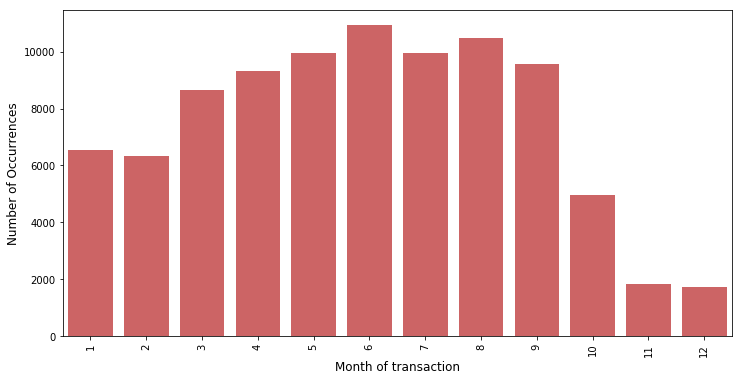

In [9]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

In [10]:
# parcelid is not unique but duplicate is less than 1%. seems ignorable 
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

In [11]:
prop_df = pd.read_csv("./properties_2016.csv")
prop_df.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [12]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


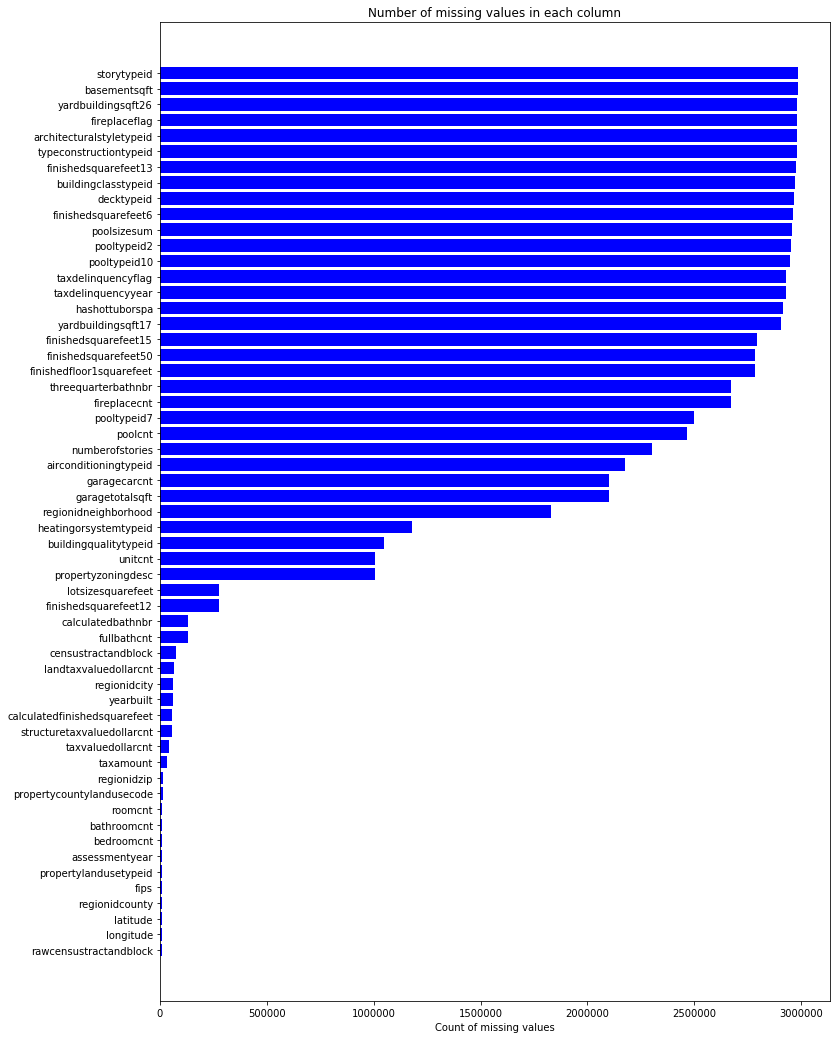

In [13]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
# width = 0.9 seems not working?
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Let us explore the latitude and longitude variable to begin with.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


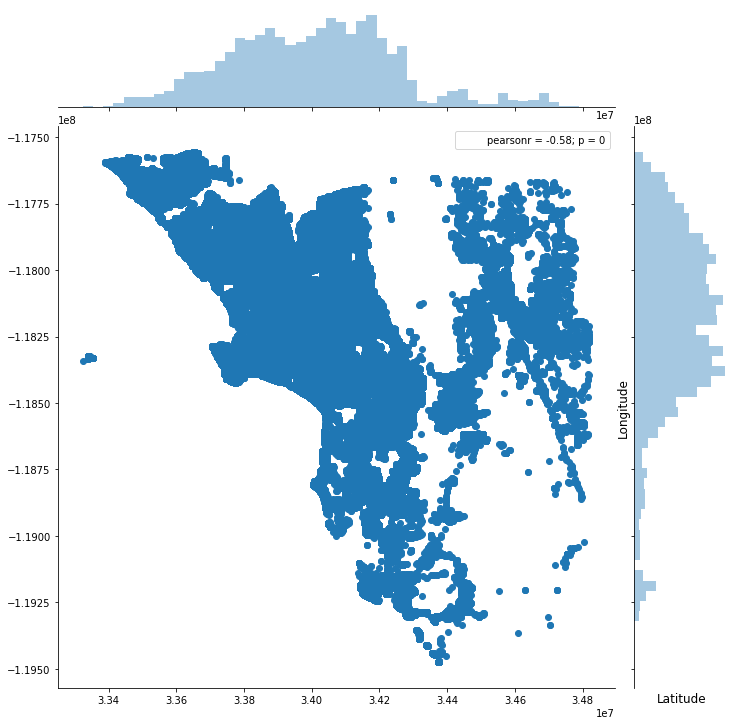

In [14]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
# can make a map like google earth? or with county boundary?

From the data page, *we are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.*

We have about 90,811 rows in train but we have about 2,985,217 rows in properties file. So let us merge the two files and then carry out our analysis. 

In [15]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


Now let us check the dtypes of different types of variable.

In [16]:
# pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


Almost all are float variables with few object (categorical) variables. Let us get the count. 

In [17]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


Now let us check the number of Nulls in this new merged dataset.

In [18]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


Four columns have missing values 99.9% of the times.!

**Univariate Analysis:**

Since there are so many variables, let us first take the 'float' variables alone and then get the correlation with the target variable to see how they are related.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


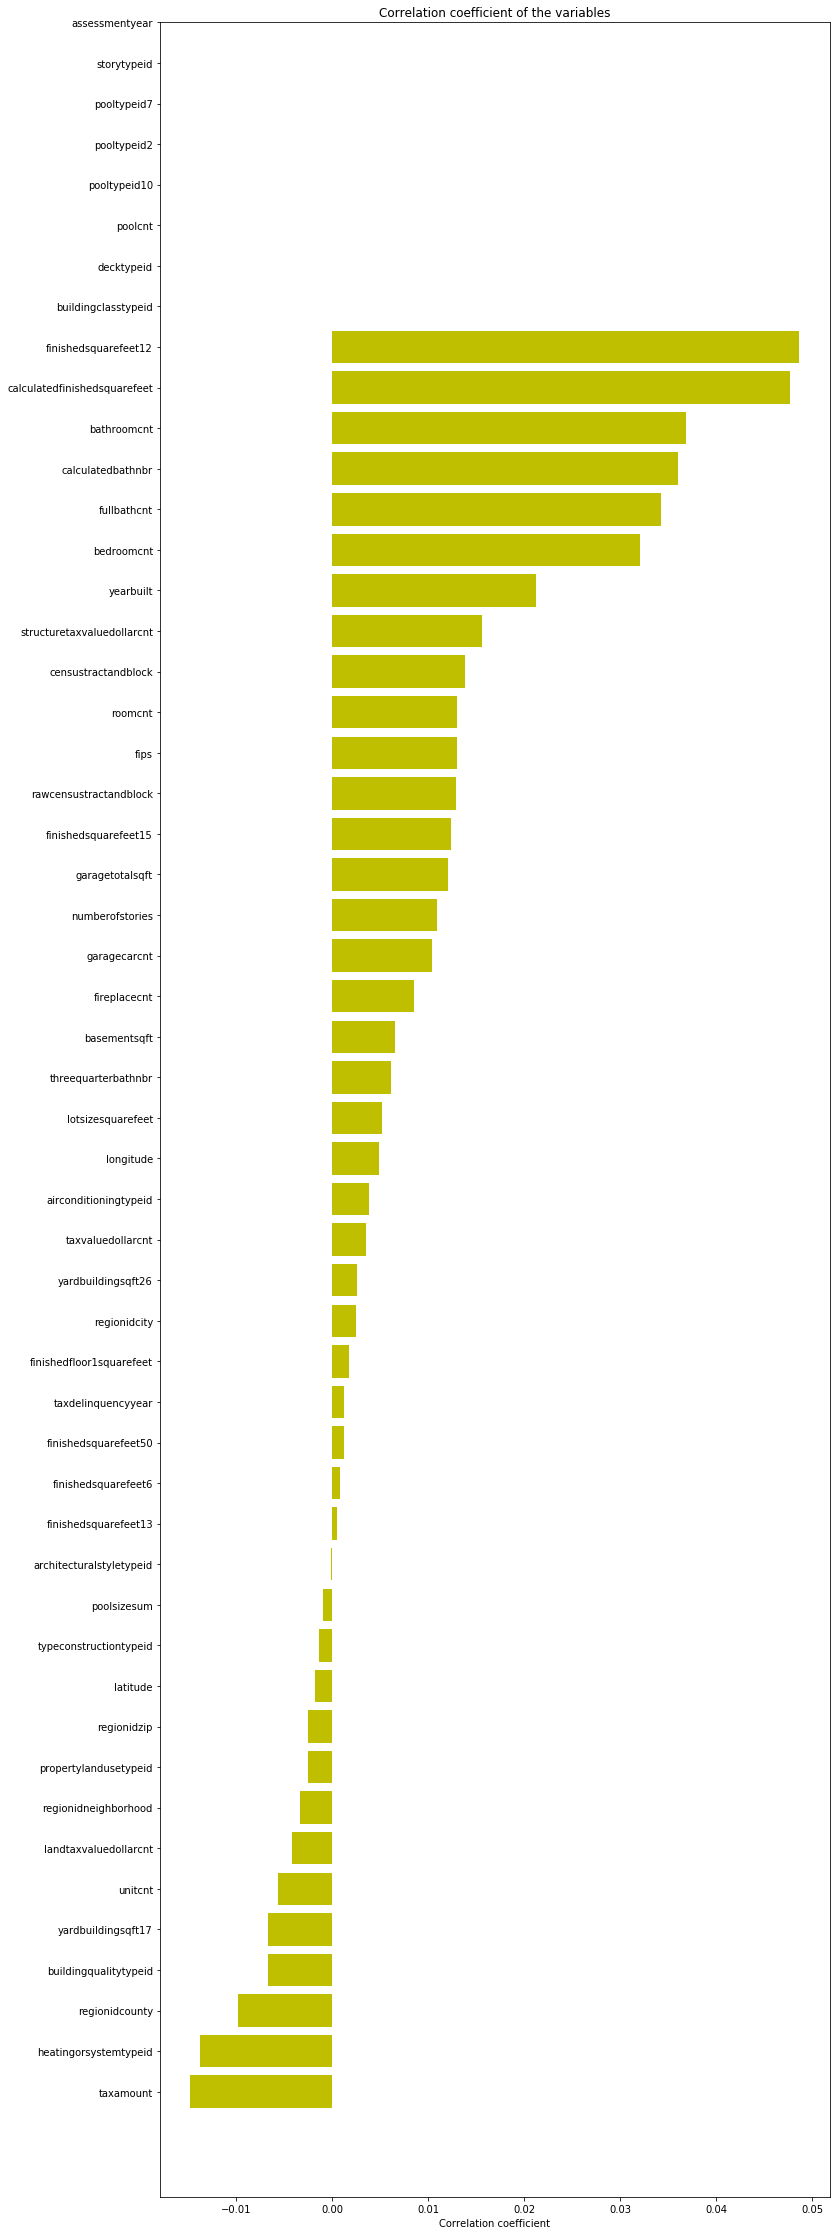

In [19]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values, inplace=True)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

The correlation of the target variable with the given set of variables are low overall. 

There are few variables at the top of this graph without any correlation values. I guess they have only one unique value and hence no correlation value. Let us confirm the same.

In [20]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


Let us take the variables with high correlation values and then do some analysis on them. 

In [21]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


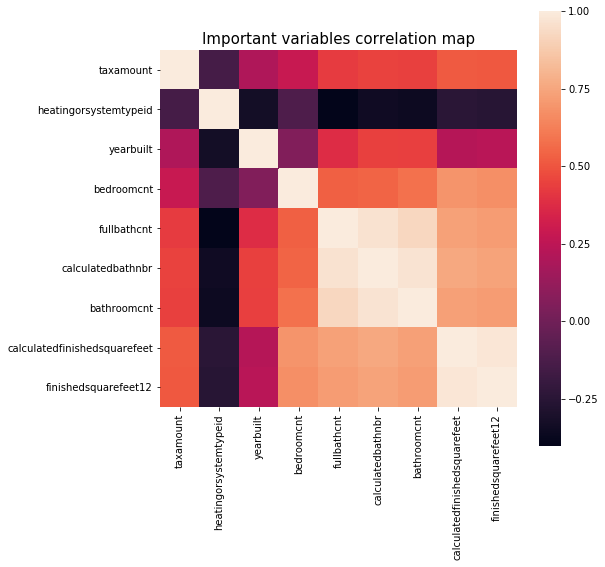

In [22]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

The important variables themselves are very highly correlated.! Let us now look at each of them.

**Finished SquareFeet 12:**

Let us seee how the finished square feet 12 varies with the log error.

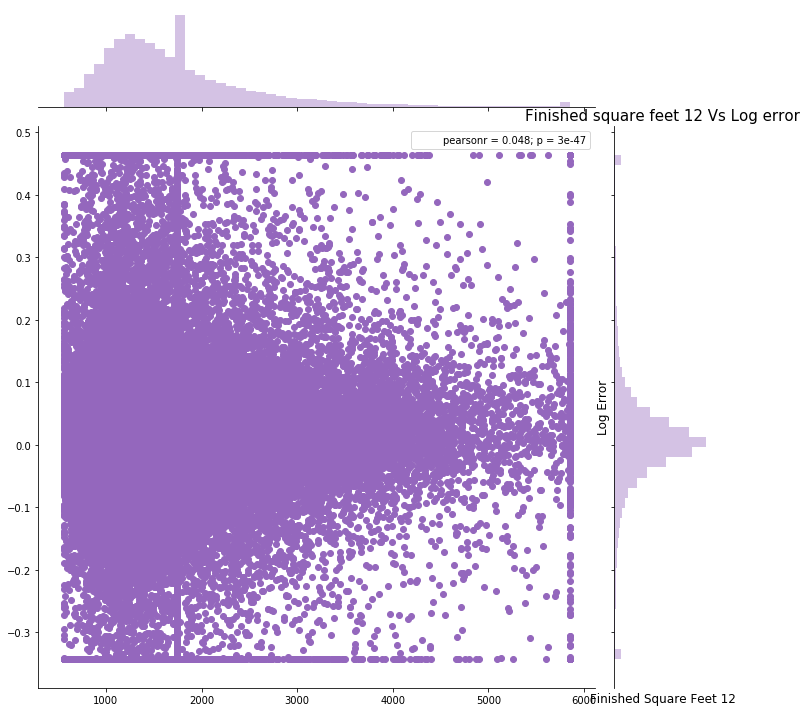

In [23]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Seems the range of logerror narrows down with increase in finished square feet 12 variable. Probably larger houses are easy to predict?

**Calculated finished square feet:**

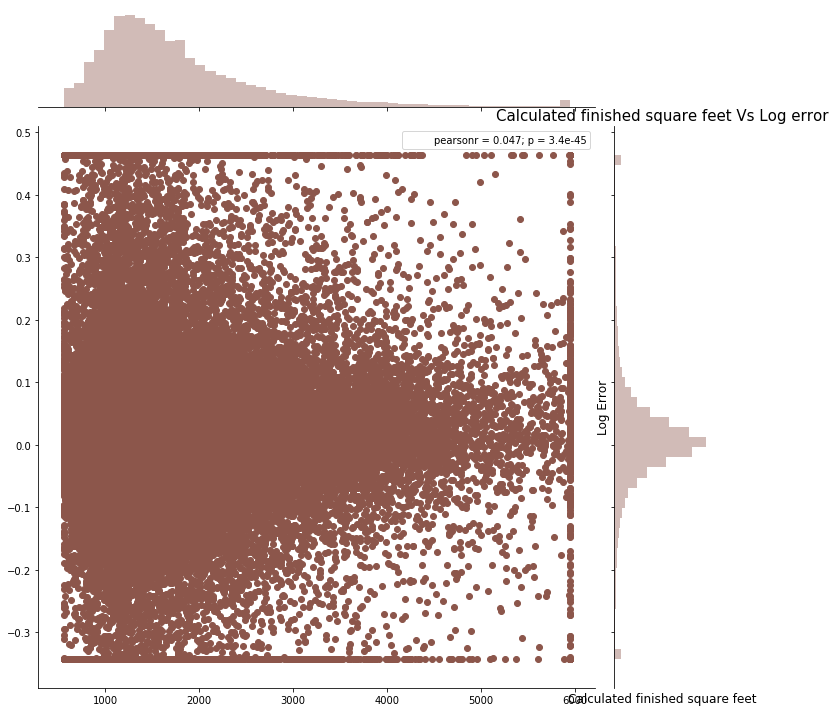

In [24]:
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

Here as well the distribution is very similar to the previous one. No wonder the correlation between the two variables are also high.

**Bathroom Count:**

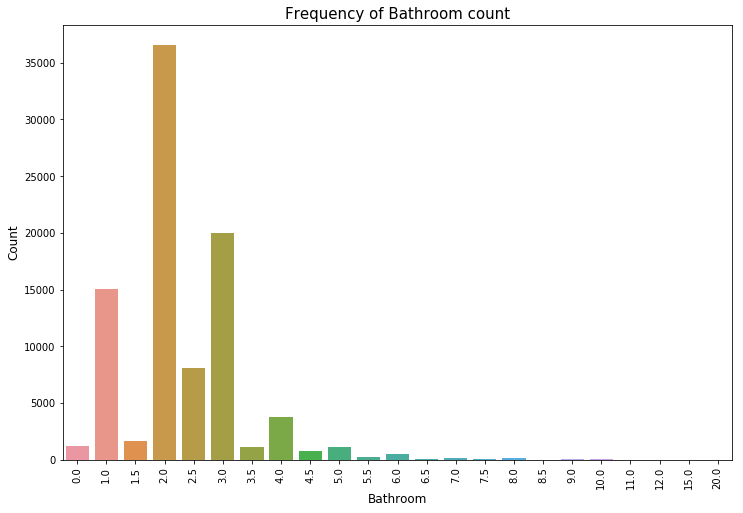

In [25]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

There is an interesting 2.279 value in the bathroom count.

Edit: As MihwaHan pointed in the comments, this is the mean value :)

Now let us check how the log error changes based on this.

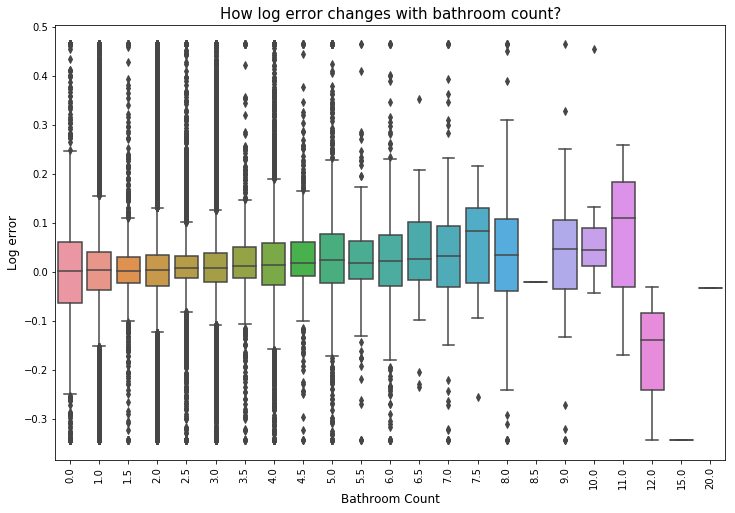

In [26]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

**Bedroom count:**

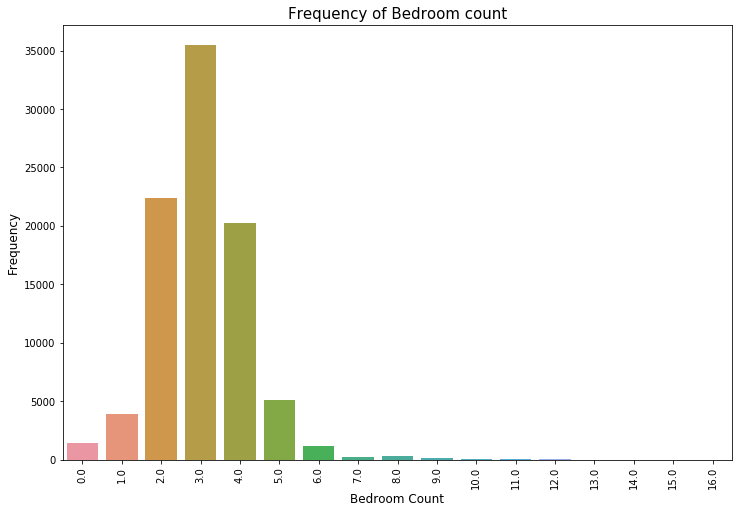

In [27]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

3.03 is the mean value with which we replaced the Null values.

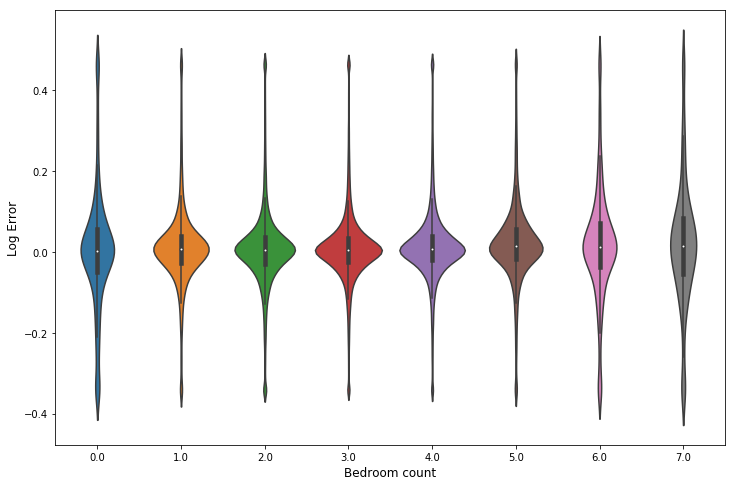

In [28]:
train_df['bedroomcnt'].loc[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

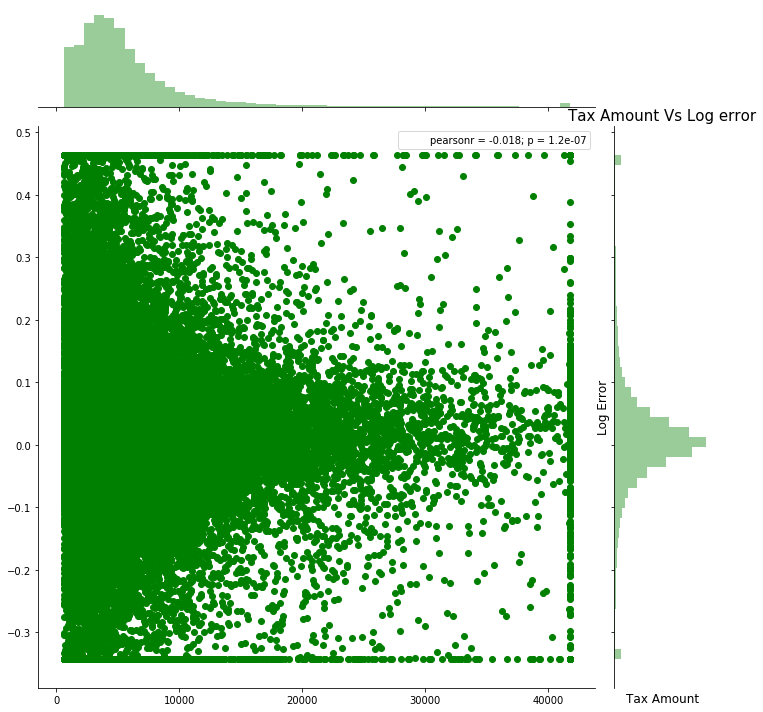

In [29]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

**YearBuilt:**

Let us explore how the error varies with the yearbuilt variable.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


AttributeError: 'DataFrame' object has no attribute 'sort'

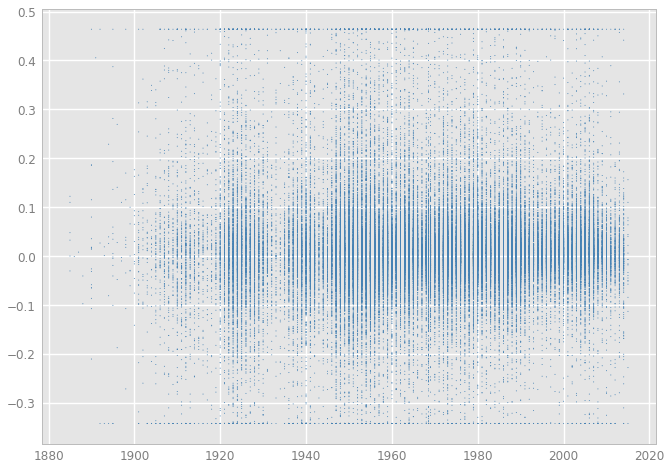

In [30]:
# error. can do with seaborn?
from ggplot import *
ggplot(aes(x='yearbuilt', y='logerror'), data=train_df) + \
    geom_point(color='steelblue', size=1) + \
    stat_smooth()

There is a minor incremental trend seen with respect to built year.

Now let us see how the logerror varies with respect to latitude and longitude.

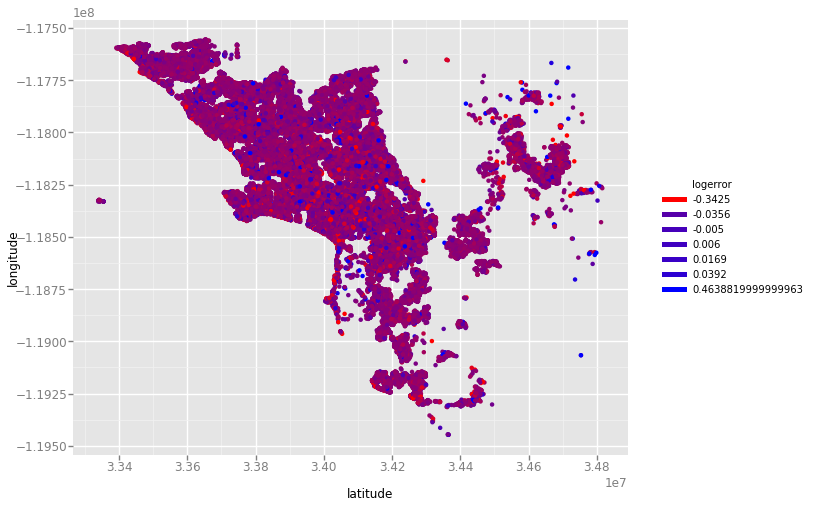

<ggplot: (296446412)>

In [31]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

There are no visible pockets as such with respect to latitude or longitude atleast with the naked eye.

Let us take the variables with highest positive correlation and highest negative correlation to see if we can see some visible patterns.

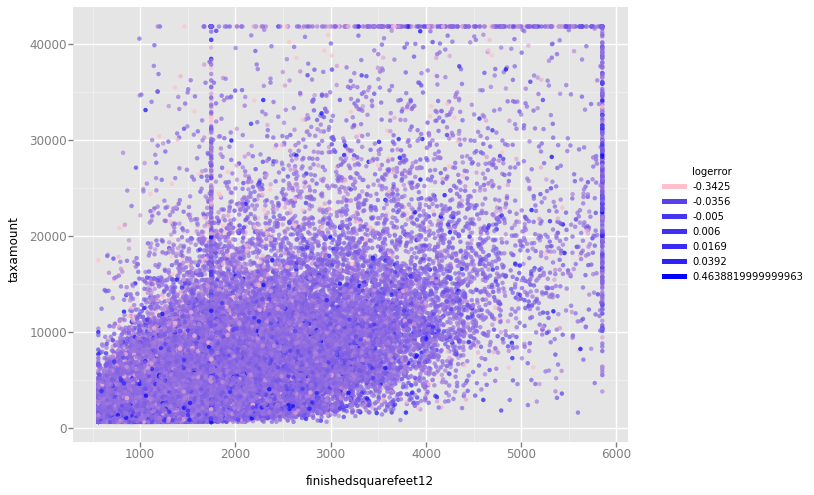

<ggplot: (-9223372036561698830)>

In [32]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_point(alpha=0.7) + \
    scale_color_gradient(low = 'pink', high = 'blue')

There are no visible patterns here as well. So this is going to be a hard competition to predict I guess.


We had an understanding of important variables from the univariate analysis. But this is on a stand alone basis and also we have linearity assumption. Now let us build a non-linear model to get the important variables by building Extra Trees model.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


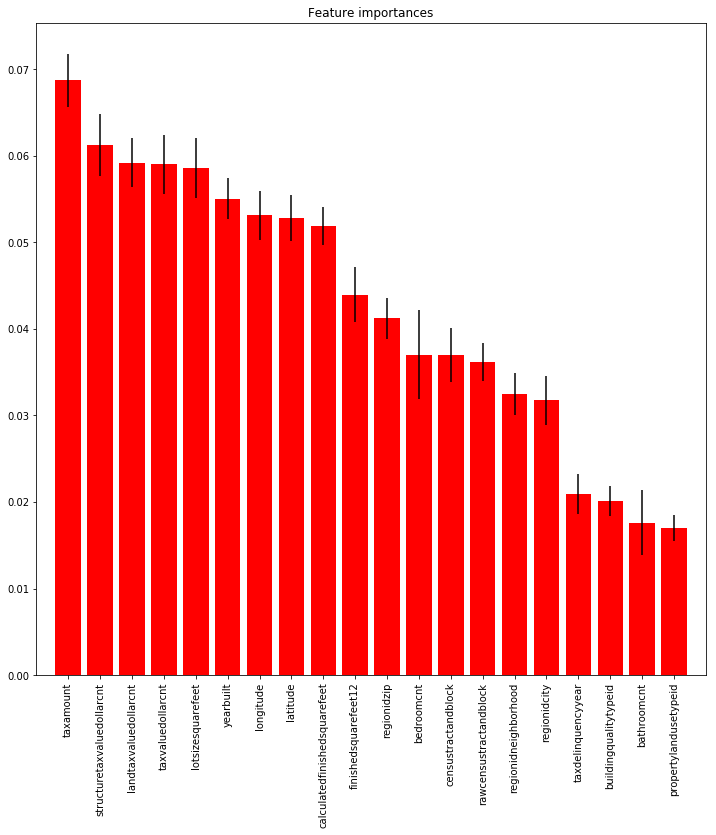

In [33]:
train_y = train_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Seems "tax amount" is the most importanct variable followed by "structure tax value dollar count" and "land tax value dollor count"



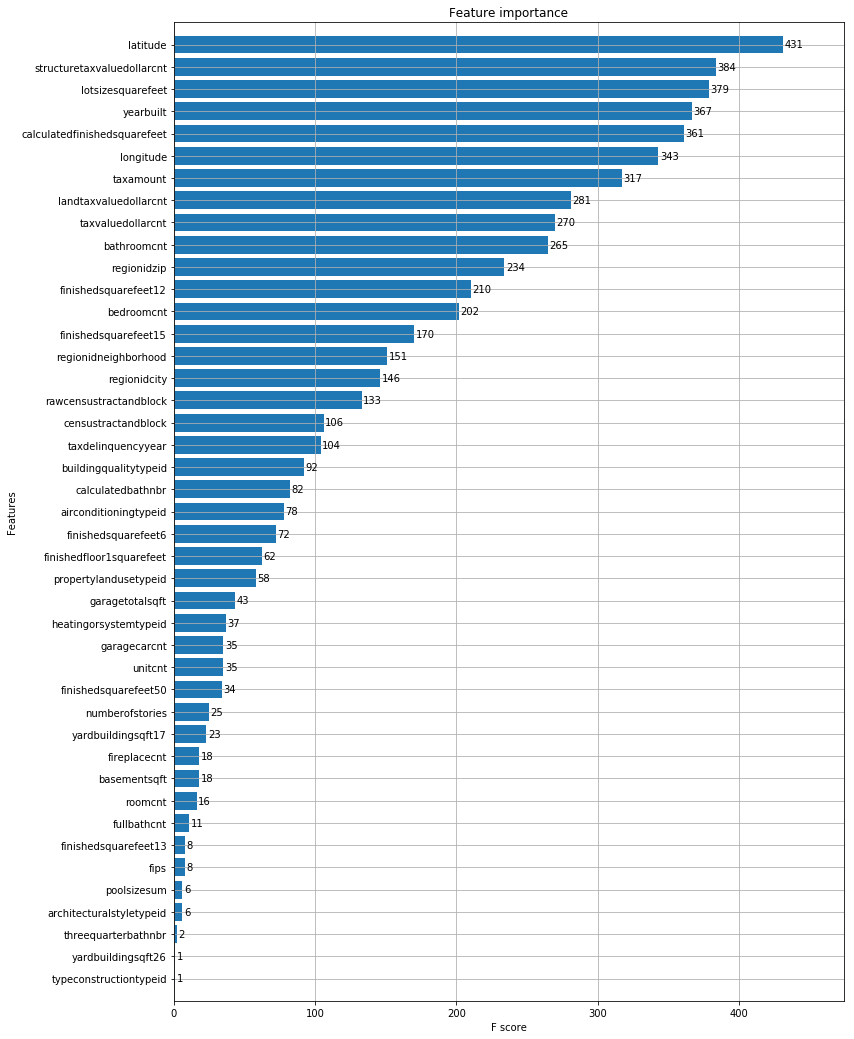

In [45]:
# eta: 0.05, 0.2 - no big difference
# max_depth: 8, 3 - different
# subsample: 0.7, 0.5 - no big difference
# colsample_bytree: 0.7, 1 - no big difference
# silent: 0 - print messages but not working in notebook?
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# how to read f-score https://stats.stackexchange.com/questions/49226/how-to-interpret-f-measure-values
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'silent': 0,
    'seed' : 0
}
dtrain = xgb.DMatrix(train_df, train_y, feature_names=train_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

#different result from original notebook from kaggle board. now latitude is the most important feature
Using xgboost, the important variables are 'structured tax value dollar count' followed by 'latitude' and 'calculated finished square feet' 